In [1]:
import os
dir_ = 'data' 
Classes = os.listdir(dir_)
Classes

['Karacadag', 'Ipsala', 'Arborio', 'Basmati', 'Jasmine']

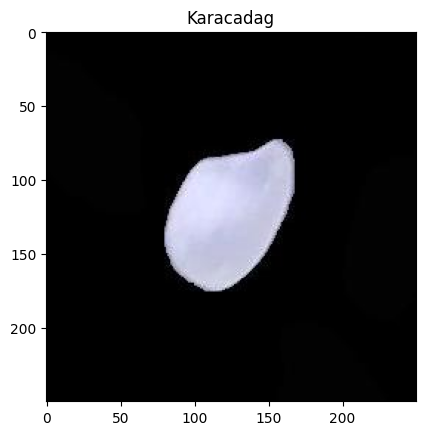

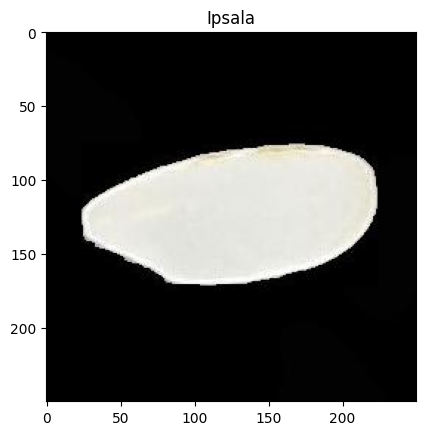

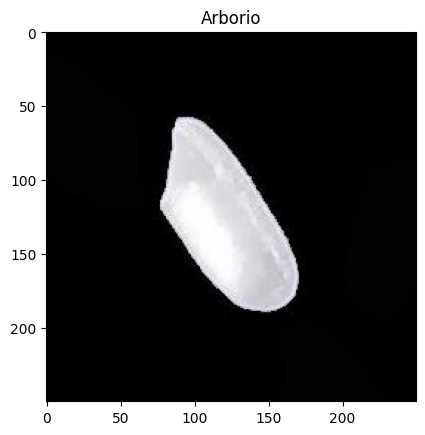

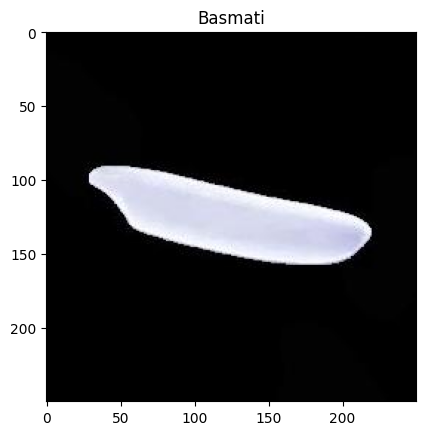

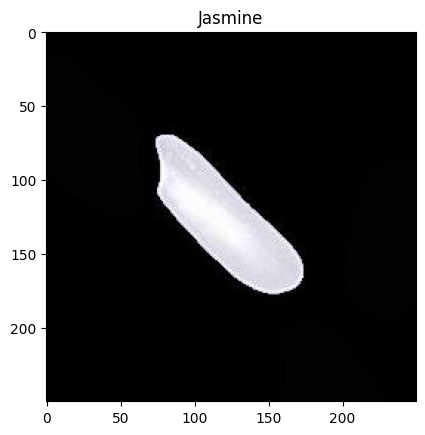

In [2]:
# plot for each class 5 images with the class name.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import numpy as np

for Class in Classes:
    images = os.listdir(dir_ + '/' + Class)
    rand_images = random.sample(images, 1)
    for image in rand_images:
        img = mpimg.imread(dir_ + '/' + Class + '/' + image)
        plt.imshow(img)
        plt.title(Class)
        plt.show()


In [3]:
# plot the number of pictures in each class
num_images = []
for Class in Classes:
    images = os.listdir(dir_ + '/' + Class)
    num_images.append(len(images))
num_images


[15000, 15000, 15000, 15000, 15000]

In [4]:
from PIL import Image

all_sizes = {}

for Class in Classes:
    class_path = os.path.join(dir_, Class)
    image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    
    sizes = set()
    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        with Image.open(image_path) as img:
            sizes.add(img.size)
    
    all_sizes[Class] = sizes  # Store unique sizes found in each class

all_sizes

{'Karacadag': {(250, 250)},
 'Ipsala': {(250, 250)},
 'Arborio': {(250, 250)},
 'Basmati': {(250, 250)},
 'Jasmine': {(250, 250)}}

In [5]:
output_dir = 'resized_data'
os.makedirs(output_dir, exist_ok=True)

new_size = (128, 128)

for Class in Classes:
    class_path = os.path.join(dir_, Class)
    output_class_path = os.path.join(output_dir, Class)
    os.makedirs(output_class_path, exist_ok=True)
    
    image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    
    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        output_image_path = os.path.join(output_class_path, image_file)
        
        with Image.open(image_path) as img:
            img.thumbnail(new_size)  # Keep aspect ratio
            img.save(output_image_path)  # Save to new folder

In [6]:
Classes_resized = os.listdir(output_dir)
Classes_resized

['Karacadag', 'Ipsala', 'Arborio', 'Basmati', 'Jasmine']

In [7]:
all_sizes = {}

for Class in Classes_resized:
    class_path = os.path.join(output_dir, Class)
    image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    
    sizes = set()
    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        with Image.open(image_path) as img:
            sizes.add(img.size)
    
    all_sizes[Class] = sizes  # Store unique sizes found in each class

all_sizes

{'Karacadag': {(128, 128)},
 'Ipsala': {(128, 128)},
 'Arborio': {(128, 128)},
 'Basmati': {(128, 128)},
 'Jasmine': {(128, 128)}}

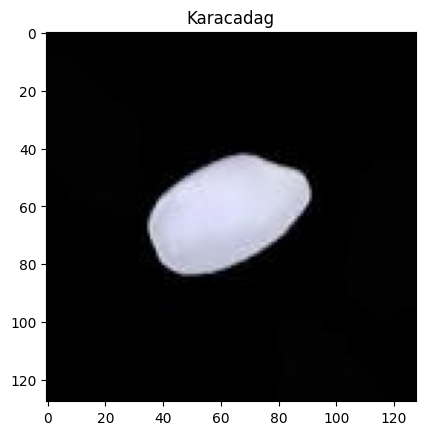

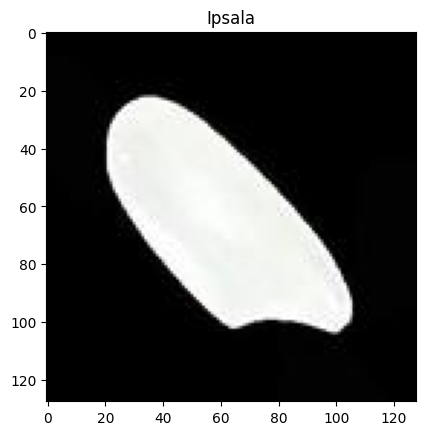

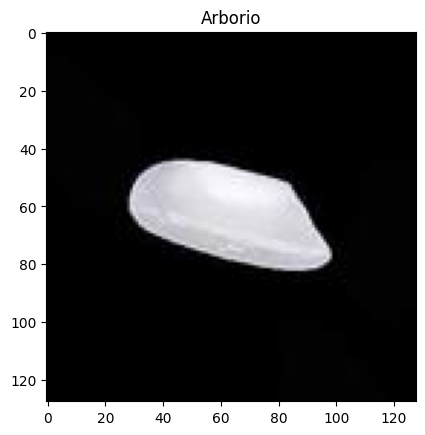

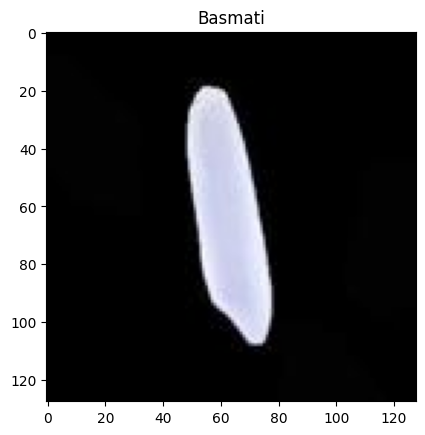

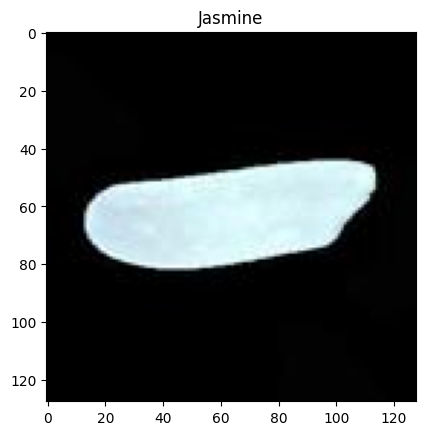

In [8]:
Classes = os.listdir('resized_data')

for Class in Classes:
    images = os.listdir(dir_ + '/' + Class)
    rand_images = random.sample(images, 1)
    for image in rand_images:
        img = mpimg.imread('resized_data' + '/' + Class + '/' + image)
        plt.imshow(img)
        plt.title(Class)
        plt.show()

---

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import os

# Define the CNN model
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # Image size is 128x128, after 2 pooling layers: 32x32
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load dataset
dataset_path = 'resized_data'
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)

# Split dataset into train, validation, and test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 52500, Val: 11250, Test: 11250


In [11]:
import wandb

# Init W&B Run (kannst du weiter oben setzen, oder dynamisch in deiner train_and_evaluate-Funktion)
wandb.init(project="image-classification", name="baseline_model", config={
    "architecture": "BaselineCNN",
    "epochs": 10,
    "batch_size": 32,
    "learning_rate": 0.001,
    "optimizer": "SGD"
})

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: oliver-pejic (oliver-pejic-fachhochschule-nordwestschweiz-fhnw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [12]:
def train_and_evaluate(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)

        # Validation
        model.eval()
        val_loss, correct, total = 0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct / total)

        # W&B Logging
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_losses[-1],
            "train_accuracy": train_accuracies[-1],
            "val_loss": val_losses[-1],
            "val_accuracy": val_accuracies[-1],
        })

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [13]:
# Initialize and train model using only the first 50 images of each class
train_dataset_small = torch.utils.data.Subset(train_dataset, range(100*5))
val_dataset_small = torch.utils.data.Subset(val_dataset, range(20*5))
test_dataset_small = torch.utils.data.Subset(test_dataset, range(20*5))

train_loader_small = DataLoader(train_dataset_small, batch_size=batch_size, shuffle=True)
val_loader_small = DataLoader(val_dataset_small, batch_size=batch_size, shuffle=False)
test_loader_small = DataLoader(test_dataset_small, batch_size=batch_size, shuffle=False)

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score
import torch

def compute_metrics(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    # Berechnung der Metriken (hier wird 'macro' verwendet, damit alle Klassen gleichgewichtet werden)
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro")
    
    return precision, recall, f1

In [16]:
def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [17]:
# 2. Modell vorbereiten und trainieren
baseline_model = BaselineCNN(num_classes=5)
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(
    baseline_model,
    train_loader_small,
    val_loader_small,
    num_epochs=wandb.config.epochs,
    learning_rate=wandb.config.learning_rate
)

# 3. Evaluation auf Testdaten
precision, recall, f1 = compute_metrics(baseline_model, test_loader_small)
test_accuracy = test_model(baseline_model, test_loader_small)

# 4. Metriken an W&B loggen
wandb.log({
    "test_precision": precision,
    "test_recall": recall,
    "test_f1_score": f1,
    "test_accuracy": test_accuracy
})

# 5. Modell speichern
torch.save(baseline_model.state_dict(), "baseline_model.pth")
wandb.save("baseline_model.pth")

Epoch [1/10], Train Loss: 1.5997, Train Acc: 18.40%, Val Loss: 1.5535, Val Acc: 32.00%
Epoch [2/10], Train Loss: 1.5026, Train Acc: 40.40%, Val Loss: 1.4426, Val Acc: 46.00%
Epoch [3/10], Train Loss: 1.3493, Train Acc: 43.00%, Val Loss: 1.2120, Val Acc: 55.00%
Epoch [4/10], Train Loss: 1.0930, Train Acc: 62.00%, Val Loss: 1.0161, Val Acc: 66.00%
Epoch [5/10], Train Loss: 0.8872, Train Acc: 65.80%, Val Loss: 0.7854, Val Acc: 66.00%
Epoch [6/10], Train Loss: 0.7433, Train Acc: 62.00%, Val Loss: 0.7103, Val Acc: 67.00%
Epoch [7/10], Train Loss: 0.6092, Train Acc: 75.40%, Val Loss: 0.5679, Val Acc: 92.00%
Epoch [8/10], Train Loss: 0.5217, Train Acc: 77.80%, Val Loss: 0.5627, Val Acc: 60.00%
Epoch [9/10], Train Loss: 0.4921, Train Acc: 77.60%, Val Loss: 0.4719, Val Acc: 85.00%
Epoch [10/10], Train Loss: 0.5083, Train Acc: 76.20%, Val Loss: 0.6248, Val Acc: 74.00%
Test Accuracy: 72.00%


['/Users/oliverpejic/Documents/Classes/del_mc_25/wandb/run-20250407_013819-k85jfrqm/files/baseline_model.pth']